In [1]:
!pip install natasha
!pip install selenium 

In [14]:
from selenium import webdriver
import re
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get("https://www.vpgazeta.ru/")
hrefs = driver.find_elements_by_xpath("//a")  

In [15]:
article_urls = []
pn_url = ""
for hr in hrefs:
    url = hr.get_attribute("href")
    part_news_url = re.search(r"news$", url)
    if part_news_url == None:
        pass
    else:
        pn_url = url
print(pn_url)

https://www.vpgazeta.ru/part/news


In [16]:
page_urls = []
driver_n = webdriver.Chrome('chromedriver', options=chrome_options)
driver_n.get(pn_url)
news_hrefs = driver_n.find_elements_by_xpath("//a")  
for hr in news_hrefs:
    url = hr.get_attribute("href")
    page_in_url = re.search(r"news\?", url)       
    if page_in_url == None:
        pass
    else:    
        print(url)
        page_urls.append(url)
print(page_urls)

https://www.vpgazeta.ru/part/news?srt=0&p=2
https://www.vpgazeta.ru/part/news?srt=0&p=6284
['https://www.vpgazeta.ru/part/news?srt=0&p=2', 'https://www.vpgazeta.ru/part/news?srt=0&p=6284']


In [17]:
all_pages = []
unvsl_str = page_urls[0][:-1]
end_str = page_urls[-1][-4:]
numb = int(end_str)
for i in range(2): #пополняем ссылками news...=0 и news...=1
    purl = f"{unvsl_str}{i}"
    all_pages.append(purl)
del all_pages[0]  #удалим news...=0, тк не существует
print(all_pages)

['https://www.vpgazeta.ru/part/news?srt=0&p=1']


In [18]:
%%time
article_urls = []
for page_url in all_pages:
    driver_p = webdriver.Chrome('chromedriver', options=chrome_options)
    driver_p.get(page_url)
    atcl_hrefs = driver_p.find_elements_by_xpath("//a")  
    for ahr in atcl_hrefs:
        url = ahr.get_attribute("href")
#         print(f"{url}")
        article_in_url = re.search(r"article\/\d+", url)
        if article_in_url == None:
            pass
        else:
            article_urls.append(url)
print(article_urls)

['https://www.vpgazeta.ru/article/114950', 'https://www.vpgazeta.ru/article/114949', 'https://www.vpgazeta.ru/article/114948', 'https://www.vpgazeta.ru/article/114947', 'https://www.vpgazeta.ru/article/114946', 'https://www.vpgazeta.ru/article/114945', 'https://www.vpgazeta.ru/article/114944', 'https://www.vpgazeta.ru/article/114943', 'https://www.vpgazeta.ru/article/114942', 'https://www.vpgazeta.ru/article/114915', 'https://www.vpgazeta.ru/article/114941', 'https://www.vpgazeta.ru/article/114940']
Wall time: 28.9 s


In [6]:
with open("demo_articles.txt", "w", encoding = "utf-8") as f:
    for element in article_urls:
        f.write(element)
        f.write('\n')

In [7]:
with open("demo_articles.txt", "r", encoding = "utf-8") as f:
    urls = f.read()
    urls = urls.split('\n')
    del urls[-1]
    articles_texts = []
    for url in urls:
        print(url)
        driver_u = webdriver.Chrome('chromedriver', options=chrome_options)
        driver_u.get(url)
        texts = driver_u.find_elements_by_xpath("//span[@class='norm std']")
        add_ = []
        for tx in texts:
            real_text = tx.text
            add_.append(real_text)
        streal_text = ' '.join(add_)
        articles_texts.append(streal_text)
        
# 'chromedriver', options=chrome_options

https://www.vpgazeta.ru/article/114934
https://www.vpgazeta.ru/article/114933
https://www.vpgazeta.ru/article/114932
https://www.vpgazeta.ru/article/114928
https://www.vpgazeta.ru/article/114927
https://www.vpgazeta.ru/article/114926
https://www.vpgazeta.ru/article/114921
https://www.vpgazeta.ru/article/114925
https://www.vpgazeta.ru/article/114924
https://www.vpgazeta.ru/article/114923
https://www.vpgazeta.ru/article/114922
https://www.vpgazeta.ru/article/114920


In [14]:
with open("demo_articles.txt", "r", encoding = "utf-8") as f:
    urls = f.read()
    urls = urls.split('\n')
    del urls[-1]
    articles_dates = []
    for url in urls:
        driver_d = webdriver.Chrome('chromedriver', options=chrome_options)
        driver_d.get(url)
#         dates = driver_d.find_elements_by_xpath("//span[@class='smaller2']")
        dates = driver_d.find_elements_by_class_name("smaller2")
        print("what")
        print(dates)
        for dt in dates:
            print('here')
            print(dt)
            real_dt = dt.text
            articles_dates.append(real_dt)

what
[<selenium.webdriver.remote.webelement.WebElement (session="85b56ba992b406f0a7e408198907fafb", element="c43c4276-ea22-4840-af30-ebcb9ce6e257")>, <selenium.webdriver.remote.webelement.WebElement (session="85b56ba992b406f0a7e408198907fafb", element="f576d1c3-b452-43a5-9930-bdb2e5a3721b")>, <selenium.webdriver.remote.webelement.WebElement (session="85b56ba992b406f0a7e408198907fafb", element="3e50c588-cc0b-44cb-9ab5-48561088f290")>, <selenium.webdriver.remote.webelement.WebElement (session="85b56ba992b406f0a7e408198907fafb", element="aec782dc-140a-4fd4-bdd0-89c78f7458c8")>, <selenium.webdriver.remote.webelement.WebElement (session="85b56ba992b406f0a7e408198907fafb", element="66ed45ad-2968-452d-9ba8-eba31ab0e4c8")>, <selenium.webdriver.remote.webelement.WebElement (session="85b56ba992b406f0a7e408198907fafb", element="405fec76-8716-4277-b7fb-3ec2c249171d")>, <selenium.webdriver.remote.webelement.WebElement (session="85b56ba992b406f0a7e408198907fafb", element="b58e8c31-7491-4782-8f0b-427

what
[<selenium.webdriver.remote.webelement.WebElement (session="e199da79817c8ce29075ccaebd7f7244", element="ba878fb7-e304-44ba-981d-3d054f61c2b3")>, <selenium.webdriver.remote.webelement.WebElement (session="e199da79817c8ce29075ccaebd7f7244", element="63a0d4a1-990d-4973-82aa-9cc14428e3c6")>, <selenium.webdriver.remote.webelement.WebElement (session="e199da79817c8ce29075ccaebd7f7244", element="df087b04-a207-4ac0-9fe1-6f2775fc32d6")>, <selenium.webdriver.remote.webelement.WebElement (session="e199da79817c8ce29075ccaebd7f7244", element="1669cb56-4802-4650-8b39-d8fc40a17986")>, <selenium.webdriver.remote.webelement.WebElement (session="e199da79817c8ce29075ccaebd7f7244", element="a8a4a402-7a55-4c11-9aee-3f98831fcd9d")>, <selenium.webdriver.remote.webelement.WebElement (session="e199da79817c8ce29075ccaebd7f7244", element="0aefab24-cf11-4e52-8e12-e5bdc3358add")>, <selenium.webdriver.remote.webelement.WebElement (session="e199da79817c8ce29075ccaebd7f7244", element="d48786df-8697-4292-a115-9e7

what
[<selenium.webdriver.remote.webelement.WebElement (session="08d9ff94a3dce6be1293dd2f4a03677b", element="58836e87-bc81-4ca5-bf32-364e693a9e58")>, <selenium.webdriver.remote.webelement.WebElement (session="08d9ff94a3dce6be1293dd2f4a03677b", element="91bcb79e-3c43-49f3-ad96-87ff36d4b964")>, <selenium.webdriver.remote.webelement.WebElement (session="08d9ff94a3dce6be1293dd2f4a03677b", element="9de68678-e4b9-4c66-bd6e-0e3e9d24b8d1")>, <selenium.webdriver.remote.webelement.WebElement (session="08d9ff94a3dce6be1293dd2f4a03677b", element="ba338195-2058-4622-a8e1-c1fca04aef01")>, <selenium.webdriver.remote.webelement.WebElement (session="08d9ff94a3dce6be1293dd2f4a03677b", element="5ad50d09-ae44-4996-8735-bb4d26bc06e2")>, <selenium.webdriver.remote.webelement.WebElement (session="08d9ff94a3dce6be1293dd2f4a03677b", element="bd307860-6e5b-4a15-9da7-d7aa6bd045b1")>, <selenium.webdriver.remote.webelement.WebElement (session="08d9ff94a3dce6be1293dd2f4a03677b", element="08055a9f-e464-47c7-bc8f-3c7

here
<selenium.webdriver.remote.webelement.WebElement (session="d8ac95eec665004ba797ca140477cbc5", element="644ce7ca-1a71-4f87-a69f-c64d5eb25d05")>
here
<selenium.webdriver.remote.webelement.WebElement (session="d8ac95eec665004ba797ca140477cbc5", element="3a574148-2c07-4ee5-be22-ae52889ddf98")>
here
<selenium.webdriver.remote.webelement.WebElement (session="d8ac95eec665004ba797ca140477cbc5", element="0f43af41-86ae-404f-98b2-8d8b5bc1db94")>
here
<selenium.webdriver.remote.webelement.WebElement (session="d8ac95eec665004ba797ca140477cbc5", element="bf5d95a6-d5f7-4acb-9100-e810e193535b")>
here
<selenium.webdriver.remote.webelement.WebElement (session="d8ac95eec665004ba797ca140477cbc5", element="f96c8bd4-1fb7-463d-be21-e5b4434eda90")>
here
<selenium.webdriver.remote.webelement.WebElement (session="d8ac95eec665004ba797ca140477cbc5", element="73770510-928e-4d7b-9a0f-7bbc918196dd")>
here
<selenium.webdriver.remote.webelement.WebElement (session="d8ac95eec665004ba797ca140477cbc5", element="f4af

In [26]:
articles_dts = []
re_dt = r"\d*\/\d*\/\d*"
for elem in articles_dates:
    res = re.search(re_dt, elem)
    if res == None:
        pass
    else:
        elem = elem.replace("/", ".")
        articles_dts.append(elem)
print(articles_dts)

['15/10/2020', '', '', '', '', 'КОММЕНТАРИИ', '', 'ЕЩЁ НА ТЕМУ', '', '15/10/2020', '', '', '', '', 'КОММЕНТАРИИ', '', 'ЕЩЁ НА ТЕМУ', '', '', '15/10/2020', '', '', '', '', 'КОММЕНТАРИИ', '', 'ЕЩЁ НА ТЕМУ', '', '', '15/10/2020', '', '', '', '', '', 'КОММЕНТАРИИ', '', 'ЕЩЁ НА ТЕМУ', '', '15/10/2020', '', '', '', '', 'КОММЕНТАРИИ', '', 'ЕЩЁ НА ТЕМУ', '', '', '15/10/2020', 'АВТОР:', '', '', '', '', '', 'КОММЕНТАРИИ', '', 'ЕЩЁ НА ТЕМУ', '', '15/10/2020', 'АВТОР:', '', '', '', '', '', '', 'КОММЕНТАРИИ', '', '15/10/2020', '', '', '', '', 'КОММЕНТАРИИ', '', 'ЕЩЁ НА ТЕМУ', '', '15/10/2020', '', '', '', '', '', '', '', 'КОММЕНТАРИИ', '', 'ЕЩЁ НА ТЕМУ', '', '', '15/10/2020', '', 'Фото: УГИБДД МВД по Республике Марий Эл', '', '', '', 'КОММЕНТАРИИ', '', 'ЕЩЁ НА ТЕМУ', '', '', '15/10/2020', '', 'Иллюстрация: группы «Волжск. Я в курсе!» WhatsApp 8-927-683-33-38', '', '', 'КОММЕНТАРИИ', '', 'ЕЩЁ НА ТЕМУ', '', '15/10/2020', '', '', '', 'КОММЕНТАРИИ', '', 'ЕЩЁ НА ТЕМУ', '']
['15.10.2020', '15.10.2020', '

In [40]:
with open("demo_articles.txt", "r", encoding = "utf-8") as f:
    urls = f.read()
    urls = urls.split('\n')
    del urls[-1]
    articles_ts = []
    for url in urls:
        driver_t = webdriver.Chrome('chromedriver', options=chrome_options)
        driver_t.get(url)
        ts = driver_t.find_elements_by_xpath("//h1")
#         ts = driver_t.find_elements_by_class_name("bigger4 title")
        print("what")
        print(ts)
        for tl in ts:
            print('here')
            print(tl)
            real_tl = tl.text
            print("r ", real_tl)
            articles_ts.append(real_tl)

what
[<selenium.webdriver.remote.webelement.WebElement (session="74eab27fc43e99b780d5f35fef44f878", element="6e4dde27-a707-4386-bed9-1215247fd0b8")>]
here
<selenium.webdriver.remote.webelement.WebElement (session="74eab27fc43e99b780d5f35fef44f878", element="6e4dde27-a707-4386-bed9-1215247fd0b8")>
r  В Йошкар-Оле за сутки было зарегистрировано 19 новых случаев COVID-19
what
[<selenium.webdriver.remote.webelement.WebElement (session="68a86946bc152c1c33635a51527a3459", element="8d836610-e9d6-422a-abdb-0c80ea254851")>]
here
<selenium.webdriver.remote.webelement.WebElement (session="68a86946bc152c1c33635a51527a3459", element="8d836610-e9d6-422a-abdb-0c80ea254851")>
r  В Волжске за сутки зафиксировано 12 случая заражения коронавирусом, в Волжском районе - 3
what
[<selenium.webdriver.remote.webelement.WebElement (session="0efd854be82a48732697133449ae2766", element="3e4bcf02-7a85-4300-b307-efab7a1d7d2e")>]
here
<selenium.webdriver.remote.webelement.WebElement (session="0efd854be82a487326971334

In [41]:
print(articles_ts)

['В Йошкар-Оле за сутки было зарегистрировано 19 новых случаев COVID-19', 'В Волжске за сутки зафиксировано 12 случая заражения коронавирусом, в Волжском районе - 3', 'Данные о количестве новых случаев заражения короновирусом в городах и районах Марий Эл на 15 октября', '"Цифровой музей природы" Волжска приглашает волонтеров и спонсоров...', 'В Марий Эл за минувшие сутки выявлено 39 случаев заражения коронавирусом', 'Инвалидам Волжска требуется помощь населения', 'К парикмахеру А.Потапову из г.Волжска клиенты ездят из других городов', 'В Йошкар-Оле (Марий Эл) лжесотрудники соцслужбы обокрали 93-летнего пенсионера', 'Глава Марий Эл ознакомился с новыми возможностями подготовки будущих провизоров', 'ДТП с участием школьного автобуса в Марий Эл: в ходе проверки автомобиля КамАЗ были выявлены неисправности', 'В Марий Эл с 15 по 16 октября на дорогах проходит профилактическое мероприятие «Грузовой автомобиль»', 'В Марий Эл перед судом предстанет мужчина, обвиняемый в совершении убийства']


In [2]:
from natasha import (
    Segmenter,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    
    Doc
)
from natasha import NewsNERTagger

segmenter = Segmenter()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)

In [19]:
re_name = r"([А-Я][а-я]*\s[А-Я][а-я]*)"
names = []
for a_text in articles_texts:
    sth = []
    a_text = a_text.split()
    sth.append(a_text[0])
    sth.append(a_text[1])
    strh = ' '.join(sth)
    res = re.search(re_name, strh)
    if res == None:
        names.append("No name")
        pass
    else:
        doc = Doc(strh)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)
        doc.parse_syntax(syntax_parser)
# sent = doc.sents[0]
# sent.morph.print()
        ner_tagger = NewsNERTagger(emb)
        doc.tag_ner(ner_tagger)
        ner_data = doc.ner
        print(ner_data)
        for span in doc.spans:
            if span.type == 'PER':
                names.append(strh)
            else:
                names.append("No name")

                 

        
    
# articles_texts = [x for x in articles_texts if x]
# print(articles_texts)

NERMarkup(text='Мария Морскова', spans=[Span(start=0, stop=14, type='PER')])
NERMarkup(text='Татьяна Курмаева', spans=[Span(start=0, stop=16, type='PER')])
NERMarkup(text='В Йошкар-Оле', spans=[Span(start=2, stop=12, type='LOC')])


In [42]:
with open("demo_data.txt", "w", encoding = "utf-8") as f:
    for i in range(len(urls)):
        f.write('\n')
        f.write(urls[i])
        f.write('\n')
        f.write("Поволжская правда")
        f.write('\n')
        f.write(articles_dts[i])
        f.write('\n')
        f.write(names[i])
        f.write('\n')
        f.write(articles_ts[i])
        f.write('\n')
        f.write(articles_texts[i])
        f.write('\n')
        f.write('=====')

In [7]:
from pymystem3 import Mystem
m = Mystem()

In [4]:
with open("demo_data.txt", "r", encoding = "utf-8") as f:
    data_news = f.read()
    data_news = data_news.split('=====')
    all_orgs = []
    for data_piece in data_news:
        orgs_inews = []
        data_piece = data_piece.split()
        for mostly_word in data_piece:
            doc = Doc(mostly_word)
            doc.segment(segmenter)
            doc.tag_morph(morph_tagger)
            doc.parse_syntax(syntax_parser)
# sent = doc.sents[0]
# sent.morph.print()
            ner_tagger = NewsNERTagger(emb)
            doc.tag_ner(ner_tagger)
            ner_data = doc.ner
            for span in doc.spans:
                if span.type == 'ORG':
                    org = re.sub(r'[^\w\s\']','',doc.text)
                    orgs_inews.append(org)
        all_orgs.append(orgs_inews)
print(all_orgs)
            

[['Роспотребнадзора'], ['Роспотребнадзора'], ['Роспотребнадзора', 'Оршанский'], ['МУДО', 'ВЭЦ'], ['Роспотребнадзора'], ['УФК', 'РМЭ', 'КЦСОН', 'КПП', 'ГРКЦ', 'НБ', 'РМЭ', 'Банка', 'БИК'], [], ['МВД', 'Узнайте'], ['Марийского', 'Центре', 'Центра'], ['ЙошкарОлаЗеленодольск', 'КАМАЗ', 'ПАЗ32053', 'ПАЗ32053', 'КАМАЗ', 'КАМАЗ', 'УГИБДД', 'МВД', 'Казанском'], [], ['Следственным', 'Следственного', 'МВД'], []]


In [5]:
if all_orgs[-1] == []:
    del all_orgs[-1]
print(all_orgs)

[['Роспотребнадзора'], ['Роспотребнадзора'], ['Роспотребнадзора', 'Оршанский'], ['МУДО', 'ВЭЦ'], ['Роспотребнадзора'], ['УФК', 'РМЭ', 'КЦСОН', 'КПП', 'ГРКЦ', 'НБ', 'РМЭ', 'Банка', 'БИК'], [], ['МВД', 'Узнайте'], ['Марийского', 'Центре', 'Центра'], ['ЙошкарОлаЗеленодольск', 'КАМАЗ', 'ПАЗ32053', 'ПАЗ32053', 'КАМАЗ', 'КАМАЗ', 'УГИБДД', 'МВД', 'Казанском'], [], ['Следственным', 'Следственного', 'МВД']]


In [8]:
news_orgs_lems = []
for news_orgs in all_orgs:
    str_news_orgs = ' '.join(news_orgs)
    orgs_lem = m.lemmatize(str_news_orgs)
    orgs_in1news = ' '.join(orgs_lem)
    orgs_in1news = orgs_in1news.split()
    news_orgs_lems.append(orgs_in1news)


In [9]:
def f(l):
    n = []
    for i in l:
        if i not in n:
            n.append(i)
    return n
def count_connection(some_li):
    i = 0
    total = []
    for i in range(len(some_li)-1):
        for el in some_li:
            cnctn_counter = 0
            data = []
            if el != some_li[i]:
                cnctn_counter += 1
                data.append(some_li[i])
                data.append(el)
                data.append(cnctn_counter)
                tup_data = tuple(data)
                total.append(tup_data)
    full_data = f(total)
    return full_data

cnctns = []
for oneworgs in news_orgs_lems:
    cnctn = count_connection(oneworgs)
    cnctns.append(cnctn)
for cnctn_list in cnctns:
    if cnctn_list == None:
        del cnctn_list
cnctns = [x for x in cnctns if x]
final_cnctns = []
for elem in cnctns:
    for tupletype in elem:
        final_cnctns.append(tupletype)
print(final_cnctns)    
# cnctnstr = ' '.join(cnctns)
# print(cnctnstr)

[('роспотребнадзор', 'оршанский', 1), ('мудо', 'вэц', 1), ('УФК', 'рмэ', 1), ('УФК', 'кцсон', 1), ('УФК', 'КПП', 1), ('УФК', 'ГРКЦ', 1), ('УФК', 'НБ', 1), ('УФК', 'банк', 1), ('УФК', 'бик', 1), ('рмэ', 'УФК', 1), ('рмэ', 'кцсон', 1), ('рмэ', 'КПП', 1), ('рмэ', 'ГРКЦ', 1), ('рмэ', 'НБ', 1), ('рмэ', 'банк', 1), ('рмэ', 'бик', 1), ('кцсон', 'УФК', 1), ('кцсон', 'рмэ', 1), ('кцсон', 'КПП', 1), ('кцсон', 'ГРКЦ', 1), ('кцсон', 'НБ', 1), ('кцсон', 'банк', 1), ('кцсон', 'бик', 1), ('КПП', 'УФК', 1), ('КПП', 'рмэ', 1), ('КПП', 'кцсон', 1), ('КПП', 'ГРКЦ', 1), ('КПП', 'НБ', 1), ('КПП', 'банк', 1), ('КПП', 'бик', 1), ('ГРКЦ', 'УФК', 1), ('ГРКЦ', 'рмэ', 1), ('ГРКЦ', 'кцсон', 1), ('ГРКЦ', 'КПП', 1), ('ГРКЦ', 'НБ', 1), ('ГРКЦ', 'банк', 1), ('ГРКЦ', 'бик', 1), ('НБ', 'УФК', 1), ('НБ', 'рмэ', 1), ('НБ', 'кцсон', 1), ('НБ', 'КПП', 1), ('НБ', 'ГРКЦ', 1), ('НБ', 'банк', 1), ('НБ', 'бик', 1), ('банк', 'УФК', 1), ('банк', 'рмэ', 1), ('банк', 'кцсон', 1), ('банк', 'КПП', 1), ('банк', 'ГРКЦ', 1), ('банк', 'Н

In [11]:
import matplotlib.pyplot as plt
import networkx as nx


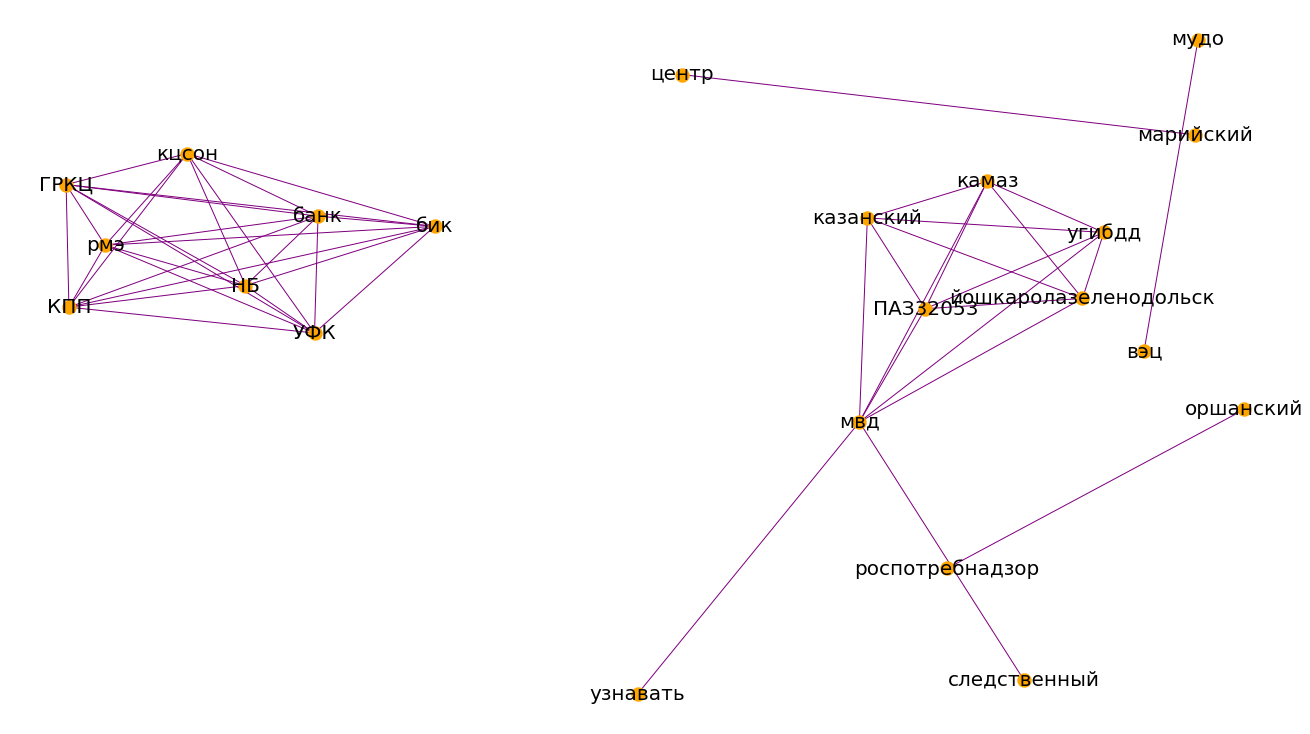

In [12]:
def buildGraph(data, thr = 0.):
    G1=nx.Graph()
    for edge_1, edge_2, w in data:
        if float(w) >= thr:
             G1.add_edge(edge_1, edge_2, penwidth=3.0, weight=10)
    return G1
def drawGraph(G):
#     pos=graphviz_layout(G)
    pos=nx.spring_layout(G,k=0.8,iterations=15)
    plt.figure(figsize=(18, 10)) #здесь можно регулировать ширину, длину размера графа
    _=nx.draw(G, pos, with_labels=True, node_color='orange', font_size=20, node_size = 200, linewidths=0.25, edge_cmap=plt.cm.Blues, edge_color='purple')
def buildAndDrawGraph(data, thr = 0.):
    G1 = buildGraph(final_cnctns, thr)
    drawGraph(G1)
    return G1
res = buildAndDrawGraph(final_cnctns)
print(res)